# helper functions

In [68]:
# Import necessary libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute, Aer
import numpy as np

import qiskit.quantum_info as qi

In [162]:
# defining function for normalization (take over from razeen)

def normalize_complex_vector(alpha_prime, beta_prime):
    # Compute the magnitude of the vector
    magnitude = np.sqrt(alpha_prime * alpha_prime.conjugate() + beta_prime * beta_prime.conjugate())
    
    # Normalize the vector
    alpha = alpha_prime / magnitude
    beta = beta_prime / magnitude
    
    return alpha, beta

# definig function for angle a

def calculate_angle_difference(alpha, beta):
    # Compute the angle (phase) of alpha and beta
    angle_alpha = np.angle(alpha)
    angle_beta = np.angle(beta)
    
    # Calculate the difference in angles
    angle_difference = angle_alpha - angle_beta
    
    return angle_difference

# definig the function for finding w

def calculate_w(alpha, beta):
    # Calculate the magnitude of alpha and beta
    magnitude_alpha = np.abs(alpha)
    magnitude_beta = np.abs(beta)
    
    # Calculate w
    w = np.arctan(magnitude_alpha / magnitude_beta)
    
    # Check the condition and adjust w accordingly
    if 0 <= w <= np.pi/2 or np.pi <= w <= 3*np.pi/2:
        w = w
    elif np.pi/2 < w < np.pi or 3*np.pi/2 < w < 2*np.pi:
        w = -w
    
    return w

In [163]:
def g_gate(qc, alpha, beta, control, target):
    # calculation from Shikhar
    alpha_prime = calculate_angle_difference(alpha, beta)
    omega = calculate_w(alpha, beta)
    G_matrix = qi.Operator([
        [np.sin(omega), np.exp(1j * alpha_prime) * np.cos(omega)],
        [np.exp(-1j * alpha_prime) * np.cos(omega), -np.sin(omega)]
    ])
    qc1 = QuantumCircuit(1)
    qc1.unitary(G_matrix,0,label="G_gate")
    if len(control) > 0:
        custom = qc1.to_gate().control(len(control))
        qc.append(custom, control + [target])
    else:
        custom = qc1.to_gate()
        qc.append(custom, [target])
    #qc.rz(alpha_prime, target)
    #qc.ry(2*omega, target)
    #if len(control) > 0:
    #    qc.mcx(control, target)
    #else: 
    #    qc.x(target)
    #qc.ry(-2*omega, target)
    #qc.rz(-alpha_prime, target)

In [164]:
def find_qubit_with_unequal_sets(T):
    n = len(T[0])  # Number of qubits

    best_qubit = None
    Max_difference = float('-inf')  # Initialize to negative infinity

    for b in range(n):
        # Split T into T_0 and T_1 based on qubit b
        T_0 = [x for x in T if x[b] == 0]
        T_1 = [x for x in T if x[b] == 1]

        # Check if both sets are non-empty
        if len(T_0) != 0 and len(T_1) != 0:
            difference = abs(len(T_0) - len(T_1))
            if difference > Max_difference:
                Max_difference = difference
                best_qubit = b
                best_T_0 = T_0
                best_T_1 = T_1

    return best_qubit,best_T_0, best_T_1

# algorithm 1

In [280]:
def algorithm1(S, coefficients, num_qubits):
    # Step 1
    C = QuantumCircuit(num_qubits, num_qubits)
    # Step 2
    dif_qubits = []
    # Step 3
    dif_values = []
    # Step 4
    T = S
    # Finding qubit with maximum difference between set T_0 and T_1 
    # This is used in step 5
    P = find_qubit_with_unequal_sets(T)
    
    # Step 5: Main loop
    while len(T) > 1:
        # Step 6: Find the qubit b
        P = find_qubit_with_unequal_sets(T)  # We already implement this logic to find the best qubit best_T_0 and best_T_1 above
        b = P[0]
        T_0 = P[1]
        T_1 = P[2]
    
        # Step 7: Append b to dif_qubits
    
        dif_qubits.append(b)
    
        if len(T_0) < len(T_1):
            # Step 9: Set T = T_0 and append 0 to dif_values
            T = T_0
            dif_values.append(0)
        else:
            # Step 10: Set T = T_1 and append 1 to dif_values
            T = T_1
            dif_values.append(1)

    # Step 14: Pop the last value appended to dif_qubits and store it as dif
    dif = dif_qubits.pop();
    print("dif is  ", dif, "\n i.e. our 3rd qubit line will act as dif since numbering started from 0 ")
    # Step 15: Pop the last value that was appended to dif_values
    dif_values.pop();
    # Step 16: Store the single element in T as x_1
    x_1 = T[0]
    print("x1 is  ", x_1)
    # Step 17
    # T_prime subset of S denote the set of strings that have the values in dif_values on the bits dif_qubits
    T_prime = [x for x in S if all(x[q] == v for q, v in zip(dif_qubits, dif_values))]
    # Step 18: Remove x_1 from T'
    T_prime.remove(x_1)
    # Step 19: Second While loop for T_prime
    while len(T_prime) > 1:
        # Step 22: Find the qubit b_prime
        R = find_qubit_with_unequal_sets(T_prime)  # Implement logic to find the best qubit
        b_prime = R[0]
        T_prime_0 = R[1]
        T_prime_1 = R[2]
    
        # Step 21: Append b to dif_qubits
    
        dif_qubits.append(b_prime)
    
        if len(T_prime_0) < len(T_prime_1):
            # Step 23: Set T = T_0 and append 0 to dif_values
            T_prime = T_prime_0
            dif_values.append(0)
        else:
            # Step 25: Set T = T_1 and append 1 to dif_values
            T_prime = T_prime_1
            dif_values.append(1)
    # Step 28
    x_2 = T_prime[0]
    print("x2 is ",x_2)
    
    # Step 29
    if x_1[dif] != 1:
        # Step 30
        print("applying NOT on: ", dif)
        C.x(dif)
        
    # Step 32: For qubit b in {1, 2, ..., n} \ dif
    for b in range(num_qubits):
        if b != dif:
            # Step 33
            if x_1[b] != x_2[b]:
                # Step 34: Add a CNOT gate targeting b controlled on dif
                print("applying CNOT on: ", dif, " ", b)
                C.cx(dif, b)
                
    # Step 37: For qubit b in dif_qubits
    for b in dif_qubits:
        # Step 38
        if x_2[b] != 1:
            # Step 39: Add a NOT gate on line b
            print("applying NOT on: ", b)
            C.x(b)
     
    # Step 42: Apply on qubit dif a G-gate controlled on the qubits in dif_qubits
    # calculate alpha
    # get c_x1
    idx_x1 = S.index(x_1)
    c_x1 = coefficients[idx_x1]
    # get c_x2
    idx_x2 = S.index(x_2)
    c_x2 = coefficients[idx_x2]

    coefficients_ = coefficients
    
    if x_1[b] == 0:
        merge_elem = x_1
        s_= S
        s_.remove(x_2)
        coefficients_[idx_x1] = c_x1+c_x2
        del coefficients_[idx_x2]
    else:
        merge_elem = x_2
        s_= S
        s_.remove(x_1)
        coefficients_[idx_x2] = c_x1+c_x2
        del coefficients_[idx_x1]
    print("applying G: on ", dif, " controlled by ", dif_qubits, " ", c_x1, " ", c_x2, " merging to: ", merge_elem)
    # normalize
    c_x1_ = np.sqrt(c_x1**2/(c_x1**2 + c_x2**2))
    c_x2_ = np.sqrt(c_x2**2/(c_x1**2 + c_x2**2))
    g_gate(C, c_x1_, c_x2_, dif_qubits, dif)
    
    return C, s_, coefficients_

# algorithm 2

In [281]:
def algorithm2(s, coefficients, num_qubits):
    #first sanity check
    if num_qubits == 0 or len(s) > 2**num_qubits or len(coefficients) != len(s):
        print("Error: params wrong")
        return
    # check if coefficients fit:
    check_sum = 0.0
    for coeff in coefficients:
        check_sum += coeff**2
    if np.isclose(check_sum, 1.0, rtol=1e-05, atol=1e-08, equal_nan=False) == False:
        print("Error: Coefficients do not sum up to 1.0: ", check_sum)
        return
    C = QuantumCircuit(num_qubits, num_qubits)
    #phi = ""
    while len(s) > 1:
        C_hat, s_, coefficients_ = algorithm1(s, coefficients, num_qubits)
        C = C.compose(C_hat)
        # merge coefficients
        print("coefficients ", coefficients_)
        coefficients = coefficients_
        s = s_
        print(coefficients)
        print(s)
    
    # add not gates
    for i in range(len(s[0])):
        if s[0][i] == 1:
            C.x(i)
    #invert
    C = C.inverse()
    
    return C

# examples

## test algo 1 - merging one step

In [282]:
# Define the input set S for quantum state  
S = [[0, 0, 0], [0, 0, 1], [0, 1, 0],[1, 0, 0],[1, 1,1 ]] # Replace this with your quantum state basis elements list
coefficients = [1/np.sqrt(5), 1/np.sqrt(5), 1/np.sqrt(5), 1/np.sqrt(5), 1/np.sqrt(5)]  # Replace this with your actual coefficients list

In [283]:
qc_state = QuantumCircuit(3, 3)
#qc_state.initialize([1/np.sqrt(5), 1/np.sqrt(5), 1/np.sqrt(5), 0, 1/np.sqrt(5), 0, 0, 1/np.sqrt(5)]) # little endian
qc_state.initialize([1/np.sqrt(5), 1/np.sqrt(5), 1/np.sqrt(5), 0, 1/np.sqrt(5), 0, 0, 1/np.sqrt(5)]) # big endian

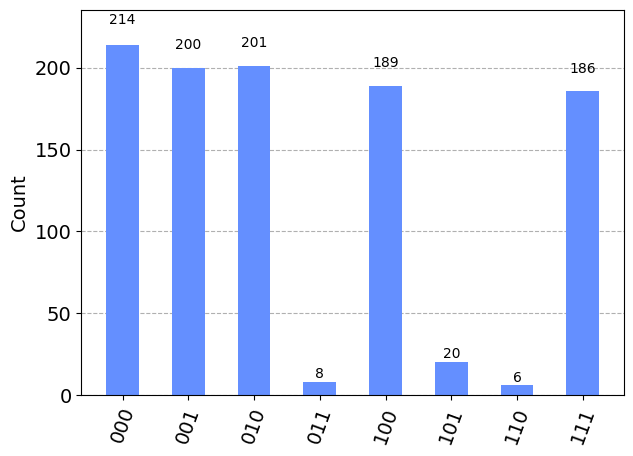

In [284]:
# just show and proof that state is correctly initialized

qc_state.measure([0,1,2], [0,1,2])
# use fake santiago backend
from qiskit.providers.fake_provider import FakeSantiagoV2
santiago = FakeSantiagoV2()
santiago.operations

from qiskit.visualization import plot_histogram

job = execute(qc_state, santiago, shots=1024) #we specify our job, which circuit to execute and how many times
result = job.result() #we extract the results from the job
counts = result.get_counts() #this time, we are not getting the state, but the counts!
plot_histogram(counts) #a new plotting method! this works for counts obviously!

In [285]:
C_1, s_1, coefficients_1 = algorithm1(S, coefficients, 3)

dif is   1 
 i.e. our 3rd qubit line will act as dif since numbering started from 0 
x1 is   [1, 1, 1]
x2 is  [1, 0, 0]
applying CNOT on:  1   2
applying G: on  1  controlled by  [0]   0.4472135954999579   0.4472135954999579  merging to:  [1, 0, 0]


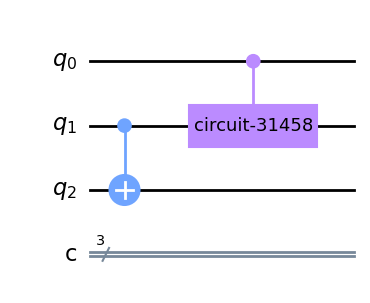

In [286]:
C_1.draw('mpl')

In [287]:
qc_state.remove_final_measurements()
qc_step1 = qc_state.compose(C_1)
qc_step1.measure([0,1,2], [0,1,2])

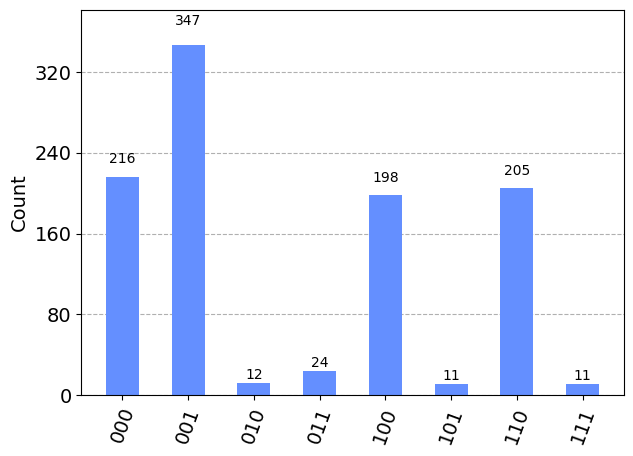

In [288]:
# use fake santiago backend
from qiskit.providers.fake_provider import FakeSantiagoV2
santiago = FakeSantiagoV2()
santiago.operations

from qiskit.visualization import plot_histogram

job = execute(qc_step1, santiago, shots=1024) #we specify our job, which circuit to execute and how many times
result = job.result() #we extract the results from the job
counts = result.get_counts() #this time, we are not getting the state, but the counts!
plot_histogram(counts) #a new plotting method! this works for counts obviously!

## test algo 1 - merging second step

In [289]:
C_2, s_2, coefficients_2 = algorithm1(s_1, coefficients_1, 3)

dif is   0 
 i.e. our 3rd qubit line will act as dif since numbering started from 0 
x1 is   [1, 0, 0]
x2 is  [0, 1, 0]
applying CNOT on:  0   1
applying G: on  0  controlled by  [1]   0.8944271909999159   0.4472135954999579  merging to:  [1, 0, 0]


In [290]:
qc_state.remove_final_measurements()
qc_step2 = qc_state.compose(C_1)
qc_step2 = qc_step2.compose(C_2)
qc_step2.measure([0,1,2], [0,1,2])

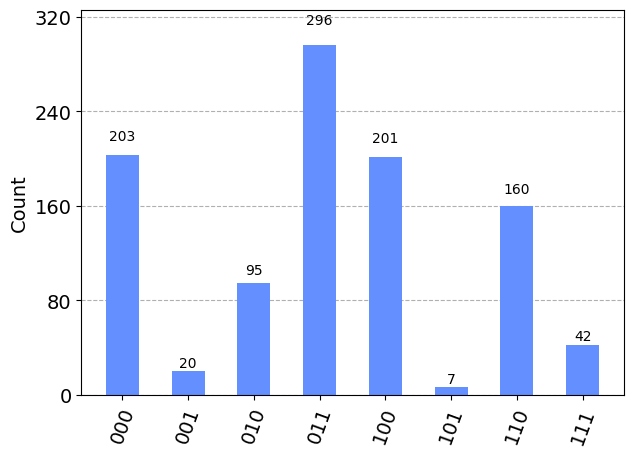

In [291]:
# use fake santiago backend
from qiskit.providers.fake_provider import FakeSantiagoV2
santiago = FakeSantiagoV2()
santiago.operations

from qiskit.visualization import plot_histogram

job = execute(qc_step2, santiago, shots=1024) #we specify our job, which circuit to execute and how many times
result = job.result() #we extract the results from the job
counts = result.get_counts() #this time, we are not getting the state, but the counts!
plot_histogram(counts) #a new plotting method! this works for counts obviously!

## test algo 2

In [240]:
# Define the input set S for quantum state  
S = [[0, 0, 0], [0, 0, 1], [0, 1, 0],[1,0,0],[1,1,1]] # Replace this with your quantum state basis elements list
coefficients = [1/np.sqrt(5), 1/np.sqrt(5), 1/np.sqrt(5), 1/np.sqrt(5), 1/np.sqrt(5)]  # Replace this with your actual coefficients list

In [241]:
C = algorithm2(S, coefficients, 3)

dif is   1 
 i.e. our 3rd qubit line will act as dif since numbering started from 0 
x1 is   [1, 1, 1]
x2 is  [1, 0, 0]
applying CNOT on:  1   2
applying G: on  1  controlled by  [0]   0.4472135954999579   0.4472135954999579  merging to:  [1, 0, 0]
coefficients  [0.4472135954999579, 0.4472135954999579, 0.4472135954999579, 0.8944271909999159]
[0.4472135954999579, 0.4472135954999579, 0.4472135954999579, 0.8944271909999159]
[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]
dif is   0 
 i.e. our 3rd qubit line will act as dif since numbering started from 0 
x1 is   [1, 0, 0]
x2 is  [0, 1, 0]
applying CNOT on:  0   1
applying G: on  0  controlled by  [1]   0.8944271909999159   0.4472135954999579  merging to:  [1, 0, 0]
coefficients  [0.4472135954999579, 0.4472135954999579, 1.3416407864998738]
[0.4472135954999579, 0.4472135954999579, 1.3416407864998738]
[[0, 0, 0], [0, 0, 1], [1, 0, 0]]
dif is   0 
 i.e. our 3rd qubit line will act as dif since numbering started from 0 
x1 is   [1, 0, 0]
x2 is  [

In [242]:
print (len(S))

1


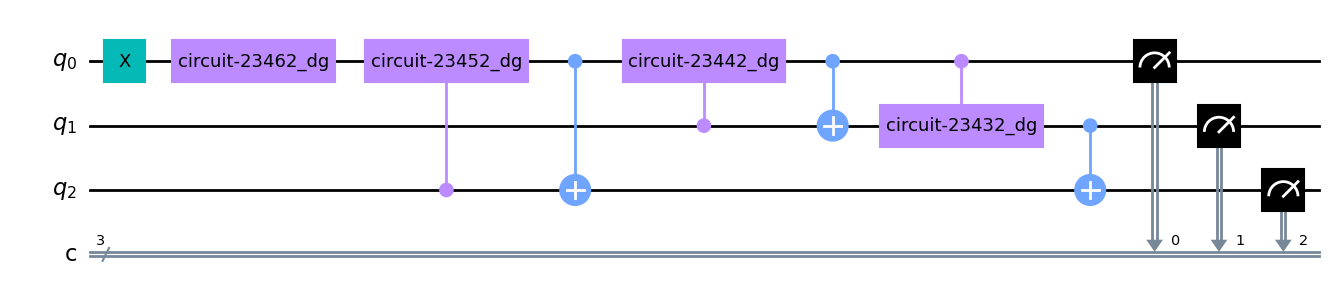

In [243]:
C.measure([0,1,2], [0,1,2])
C.draw('mpl')

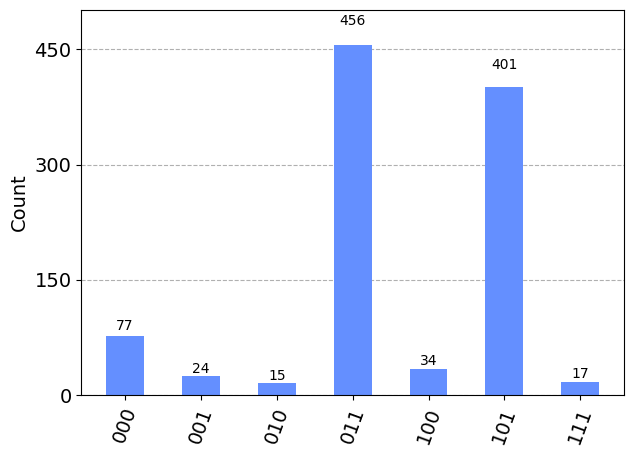

In [244]:
# use fake santiago backend
from qiskit.providers.fake_provider import FakeSantiagoV2
santiago = FakeSantiagoV2()
santiago.operations

from qiskit.visualization import plot_histogram

job = execute(C, santiago, shots=1024) #we specify our job, which circuit to execute and how many times
result = job.result() #we extract the results from the job
counts = result.get_counts() #this time, we are not getting the state, but the counts!
plot_histogram(counts) #a new plotting method! this works for counts obviously!